# Approximating Isomap with k-Nearest Neighbors and Stochastic Metric Multidimensional Scaling

See the [SMMDS notebook](https://github.com/jlmelville/drnb/blob/4ed79e809ea943073ee2ae5814d65703e691b451/notebooks/embed-pipeline/smmds.ipynb) for details on SMMDS. It's a pretty obvious stochastic version of metric MDS. Whereas MMDS involves calculating all distances pairs in the embedded output and optimizing them so they more closely resemble the ambient pairwise distances, SMMDS just does that for a random sampling in each iteration.

The advantage of this approach is that it is conceptually simple: as long as you know how to generate random numbers, a distance metric, and have access to the initial data, you don't need to do much up-front calculation or storage: just repeatedly calculate the distance between points in the input and output coordinate matrices. Ignoring the fact that trying to reproduce high-dimensional distances in the low-dimensional space is just not a good strategy in a lot (most?) cases, the trade-off is that you spend more time doing distance calculations in the high-dimensional space, which could be expensive if the data is very high-dimensional. 

If we are prepared to store the k-nearest neighbor data, then we can let something like [FAISS](https://github.com/facebookresearch/faiss) do the work off finding those efficiently (and/or offloading the effort to a GPU should you have one). Then, assuming that there is useful distance information in the nearest neighbors data, we can cache that and save ourselves the effort of doing the high-dimensional distance calculation. This does change the sampling strategy from SMMDS: instead of sampling uniformly from the data, we are going to be concentrating on local distances. We need *some* longer-distance information but maybe we come out ahead if we can concentrate on local information?

## Approximating Isomap

A further extension of this idea is from [Stochastic Proximity Embedding](https://www.pnas.org/doi/full/10.1073/pnas.242424399), a method that does pair-wise updates to approximate metric MDS. In that paper, they note that if the data is embedded on a lower-dimensional manifold, the longer distances must be a lower-bound on the true geodesic distances along the manifold (short distances are considered to be sufficiently short that the disparity between the ambient and the geodesic distance can be ignored). So they suggest comparing the embedded distances to the ambient distance during the optimization. For longer-distance pairs, embedded distances smaller than the ambient distance can't possibly be correct, so the update should be applied. Otherwise, don't apply the update: we don't know what the real distance is, but at least the lower bound is not violated. They show that this can unroll the "Swiss roll" manifold (a 2D rectangle rolled up into 3D) which the [Isomap](https://doi.org/10.1126/science.290.5500.2319) method successfully unrolled, but SPE avoids having to calculate geodesic distances the way Isomap does and should scale better.

The knn-based SMMDS approach should also be able to do this: with SPE whether an ambient distance should be considered long was based on a cutoff found by randomly sampling pairwise distances. But with the SMMDS case we can use the nearest neighbors as the near distances and apply the full MMDS update to them, and then during the random sampling make the usual UMAP assumption that all sampled "negative" points are not in the neighbor list and just apply the modified "isometric" update to them.

I have zero inspiration for what to call this variation on SMMDS, so I am going with `skmmds` for the k-nearest neighbors version of SMMDS and then `sikmmds` for the variant that approximates Isomap.

In [1]:
import drnb.embed.pipeline as pl

In [2]:
from drnb.experiment import Experiment

In [3]:
exp = Experiment(
    name="isommds", evaluations=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))]
)

I chose some datasets that cover a few bases:

* `iris` -- I think it's interesting to see what methods do with a small dataset like this. A lot of techniques are focused on big datasets so smaller simpler datasets don't get treated delicately enough.
* `s1k` -- 10 overlapping clusters in 9D. Definitely not a manifold, but UMAP and t-SNE can extract structure from it. PCA and MMDS do not.
* `mammoth` -- A low-dimensional manifold that doesn't need unfolding. It just looks like a mammoth.
* `isoswiss` and `isofaces` -- two datasets used in the Isomap paper. `isoswiss` is the Swiss roll and should unfold. `isofaces` is higher dimensional images of a face lit at different angles, but still seemed to show some sort of unrolling.
* `spheres` -- High dimensional spheres embedded in a larger gaussian distribution. Neither PCA, t-SNE nor UMAP really make a good show of embedding this.
* `mnist` -- Here as a classic high-dimensional clustered dataset that UMAP and t-SNE do a good job on.
* `tasic2018-pca50` and `macosko2015-pca50` -- two scRNAseq datasets. I'm not expecting miracles here. There are definitely clusters in both. `macosko2015` is dominated by a very large cluster which seems to make it challenging to reliably preserve the structure of any other clusters. Both of these have been pre-processed to only keep 50 PCs. This will speed up the distance calculation, but more importantly, especially in the `macosko2015` case, it does seem to give clearer clustering. I am agnostic on whether this is real structure or just from being too aggressive with PCA. However, based on doing permutation tests, I do think 50 PCs is a reasonable choice for both datasets.

In [4]:
exp.add_datasets(
    [
        "iris",
        "s1k",
        "mammoth",
        "isoswiss",
        "isofaces",
        "scurvehole",
        "spheres",
        "mnist",
        "tasic2018-pca50",
        "macosko2015-pca50",
    ]
)

In [5]:
exp.add_method("pca")
skmmds_params = dict(
    init="rand",
    learning_rate=100.0,
    n_epochs=5000,
    n_neighbors=15,
    n_samples=5,
    init_scale="knn",
    sample_strategy="inc",
    pca=50,
)
exp.add_method("skmmds", params=skmmds_params)
exp.add_method(
    "sikmmds",
    params=skmmds_params,
)

About the parameters for `skmmds` and `sikmmds`:

* It's a real pain to optimize compared to UMAP or t-SNE, requiring a learning rate that scales quite strongly with at least the dataset size, despite [Adam](https://arxiv.org/abs/1412.6980)'s best efforts.
* Even then, it needs a large number of iterations to converge.
* Most of the parameters were chosen to make sure `sikmmds` converged ok. `skmmds` is a bit more forgiving to optimize.
* I chose the learning rate by trial and error and cranked up the `n_epochs` to ensure convergence. For a given dataset you could probably do a *lot* better with fewer epochs and a suitable choice of learning rate.
* PCA initialization is not necessarily a good idea for the typical manifold example of swiss roll and S-curve due to it curling up the manifold which makes it quite hard for the algorithm to unroll it.
* Random initialization is better although it means that in the typical less-manifoldy case it takes longer for any structure to occur.
* Roughly initializing the random output with a standard deviation close the mean nearest neighbor distance at least makes the local distances more or less right, so it seems like the algorithm spends less time just reorganizing the output to be the right scale before any structure appears.
* I use the same ratio of neighbors to random samples as the UMAP defaults: 15-nearest neighbors (`n_neighbors=15`) and 5 negative examples per edge (`n_samples=5`) of the symmetrized input graph. For lower-dimensional cases you can get away with `n_samples=1`.
* `n_neighbors=15` is a bit too high for `isofaces` and you start to see a bit of "short-circuiting" (`n_neighbors=6` is the choice in the Isomap paper) but it's not a deal-breaker.
* Another way to make more efficient use of the negative sampling seems to be to apply fewer negatives early on and more later on. Intuitively it makes sense to me that you would want to have more emphasis on local self-organization of the nearest neighbors early on without too much disruption introduced by negative sampling. This is what the [NCVis](https://github.com/stat-ml/ncvis) method does, and the `sample_strategy="inc"` does effectively the same thing as that method, where the total number of negative samples is the same as what you would get if you applied `n_samples` at every epoch, but redistributed to have less than `n_samples` early on and more at the end.
* Although PCA may not be great for initialization, I do use it to reduce the dimensionality of the input dataset. This makes the repeated distance calculations in the ambient space (required during the negative sampling) more manageable. For datasets which are high-dimensional (e.g. `macosko2015`) the repeated high-dim calculations adds a *substantial* overhead to the optimization. Because both `macosko2015-pca50` and `tasic2018-pca50` were reduced to 50 PCs already, this setting is only really going to affect `mnist`.

In [6]:
exp.run()

[09:42:17] INFO     Running pca on iris                                             ]8;id=648539;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=46136;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:18] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=532325;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=100796;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py#80\80]8;;\

           INFO     Loading faiss with AVX2 support.                                   ]8;id=548885;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=829982;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#110\110]8;;\

[09:42:19] INFO     Successfully loaded faiss with AVX2 support.                       ]8;id=297936;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=75140;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#112\112]8;;\

           INFO     Running pca on s1k                                              ]8;id=721639;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=943320;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

           INFO     Running pca on mammoth                                          ]8;id=318464;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=565872;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:23] INFO     Running pca on isoswiss                                         ]8;id=585719;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=374165;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:25] INFO     Running pca on isofaces                                         ]8;id=91296;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=36066;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:26] INFO     Running pca on scurvehole                                       ]8;id=81798;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=650783;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:27] INFO     Running pca on spheres                                          ]8;id=10745;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=681989;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:28] INFO     Running pca on mnist                                            ]8;id=787822;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=257420;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:34] INFO     Running pca on tasic2018-pca50                                  ]8;id=36766;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=793841;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:36] INFO     Running pca on macosko2015-pca50                                ]8;id=322024;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=87260;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:39] INFO     Running skmmds on iris                                          ]8;id=741368;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=344843;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:46] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=863403;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=102609;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py#80\80]8;;\

           INFO     Running skmmds on s1k                                           ]8;id=604431;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=756165;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:42:52] INFO     Running skmmds on mammoth                                       ]8;id=542515;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=652596;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:44:49] INFO     Running skmmds on isoswiss                                      ]8;id=507271;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=592369;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:45:32] INFO     Running skmmds on isofaces                                      ]8;id=808301;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=644205;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:45:38] INFO     Running skmmds on scurvehole                                    ]8;id=837561;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=599482;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:46:00] INFO     Running skmmds on spheres                                       ]8;id=465742;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=824610;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:47:10] INFO     Running skmmds on mnist                                         ]8;id=57630;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=835987;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[09:59:59] INFO     Running skmmds on tasic2018-pca50                               ]8;id=304872;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=476310;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:02:19] INFO     Running skmmds on macosko2015-pca50                             ]8;id=208505;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=277991;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:08:03] INFO     Running sikmmds on iris                                         ]8;id=784623;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=977944;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:08:07] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=401955;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=110982;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py#80\80]8;;\

           INFO     Running sikmmds on s1k                                          ]8;id=331086;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=611981;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:08:13] INFO     Running sikmmds on mammoth                                      ]8;id=709551;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=585575;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:09:42] INFO     Running sikmmds on isoswiss                                     ]8;id=346117;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=97782;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:10:18] INFO     Running sikmmds on isofaces                                     ]8;id=271421;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=823131;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:10:25] INFO     Running sikmmds on scurvehole                                   ]8;id=690502;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=785997;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:10:42] INFO     Running sikmmds on spheres                                      ]8;id=63972;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=252321;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:11:47] INFO     Running sikmmds on mnist                                        ]8;id=193821;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=704866;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:25:39] INFO     Running sikmmds on tasic2018-pca50                              ]8;id=24581;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=120488;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

[10:27:36] INFO     Running sikmmds on macosko2015-pca50                            ]8;id=228347;file:///home/james/dev/drnb3/src/drnb/experiment.py\experiment.py]8;;\:]8;id=664520;file:///home/james/dev/drnb3/src/drnb/experiment.py#69\69]8;;\

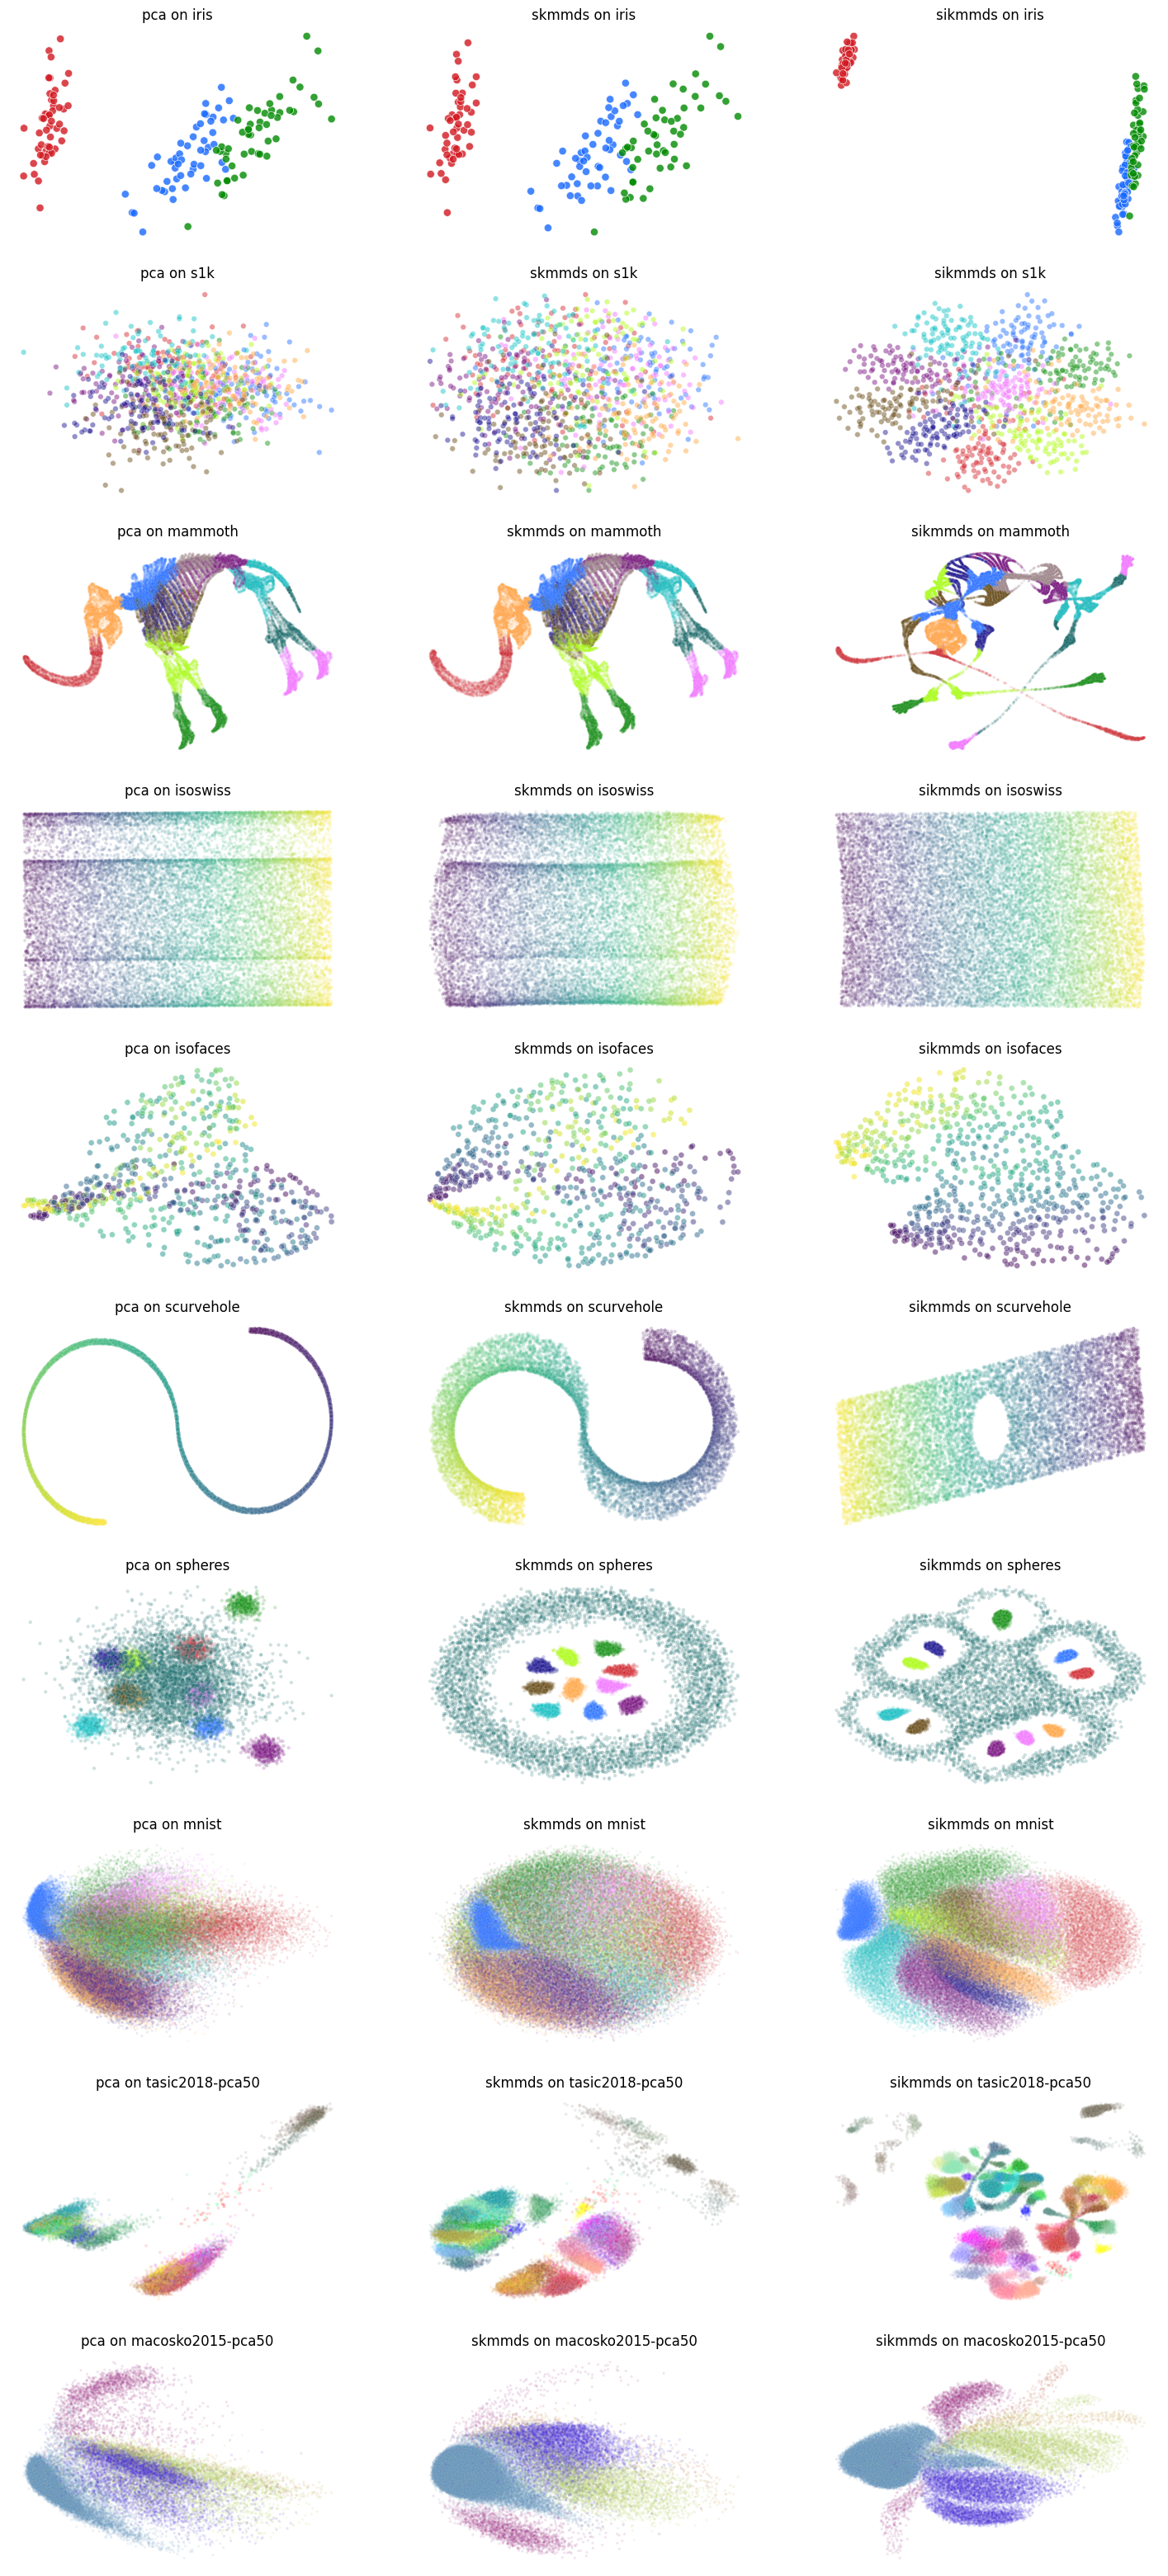

<Figure size 640x480 with 0 Axes>

In [9]:
exp.plot(methods=["pca", "skmmds", "sikmmds"])

A lot of these results look pretty ok! For `skmmds`, a lot of the output resembles what I would expect and looks like an "expanded", more circular version of what PCA produces: e.g. `iris` shows 3 clusters, the `mammoth` looks like a mammoth, `scurvehole` and `isoswiss` do not unfold but are not horrifically distorted. `tasic2018-pca50` gives results that look similar to the [SQuadMDS](https://arxiv.org/abs/2202.12087) method that got me interested in looking at these approaches again. So I think it's safe to move onto looking at what `sikmmds` does.

And I quite like some of what I see. Let's allow ourselves a small pat on the back for unrolling `isoswiss` and `scurvehole`. `isofaces` is also unrolled: the color gradation indicates a lighting direction and is more consistent than the PCA or `smmds` results. Also for non-manifold data, `iris` survives the experience and `s1k` actually shows some structure. It's interesting: it's definitely not 10 easily distinguishable blobs like you get with UMAP and t-SNE. But the radial petal-like pattern at least shows something. This could point to a downside of the method, though where clusters are getting elongated.

Now let us quickly pass over `mammoth`. It looks ludicrous. That's a definite failure. You can see the elongation issue in full effect there.

`spheres` gives a pleasing result. The PCA results don't look fantastic. The `skmmds` results definitely show the ten smaller clusters, with the larger cluster becoming a ring, which might reflect the soap-bubble like density of a high-dimensional Gaussian in an ok way (although why don't the smaller clusters which are also Gaussian look like rings?). The `sikmmds` result has the larger cluster more evenly distributed throughout the plot. The downside is that you might be a bit misled if you thought the way the ten cluster have broken symmetry to form four subclusters was significant though. However, shame on you for not re-running this multiple times with different seeds.

Maybe the years have worn my expectations down below what is appropriate, but I am very impressed by the `mnist` result, especially if you compare to the fuzzy PCA and `skmmds` results. If the results were not colored by digit I grant you that you would not say "there are definitely ten clusters there", but it's pretty darn good for just reproducing distances.

The two scRNAseq datasets also do quite well. `tasic2018-pca50` is particularly interesting as there seem to be some actual clusters forming. The `macosko2015-pca50` result also shows a pleasing development of extra structure compared to the `skmmds` result. However, the issue with the streaky elongated distributions of data is apparent.

Overall, ignoring the issues with optimization time, the final results are far from horrible (except `mammoth`, sorry animal lovers). I am surprised at how well that worked.

In [10]:
exp.save()

### What about actual Isomap?

There is a scikit-learn implementation of Isomap which I have wrapped. Unfortunately, my puny laptop RAM of 48GB is not enough to handle the demands of the algorithm, which I assume has to do a lot of work to calculate geodesic distances (I don't know if a sparse approach to such calculations exists). Also the nearest neighbor search is exact and I didn't see a way to pass a pre-calculated k-nearest neighbors object to it. So I can only show results for the smaller datasets:

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[10:52:48] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=805101;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=694802;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py#80\80]8;;\

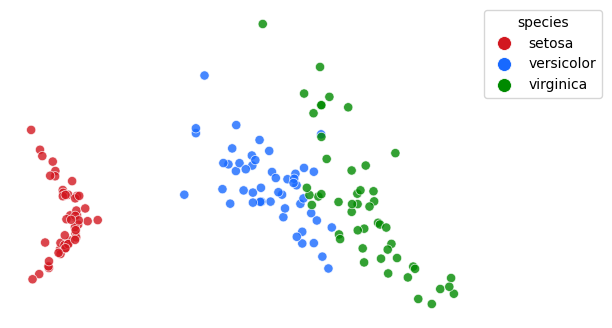

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.9386666666666668), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.99210876), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7431111111111112), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.9468000000000001), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=nan, info={'metric': 'euclidean', 'n_neighbors': 150})]

In [11]:
pl.standard_eval(
    dataset="iris",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

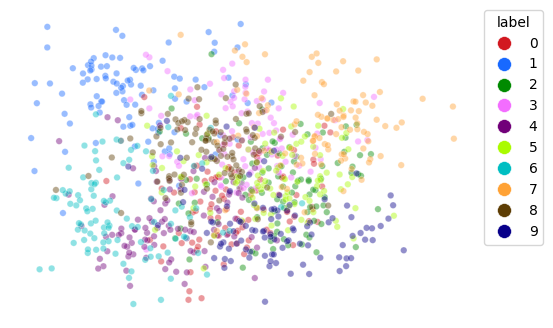

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6484), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.43440655), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.11473333333333334), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.22766000000000003), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.36676), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [12]:
pl.standard_eval(
    dataset="s1k",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

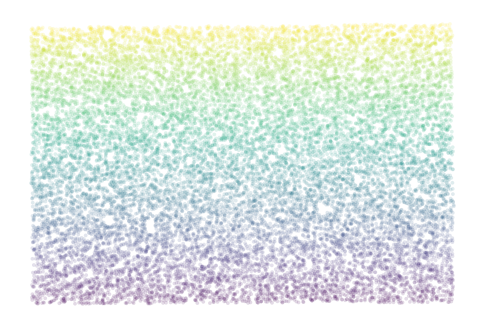

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6802699999999999), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.3617192), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.9456466666666667), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.9655600000000002), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.9797273333333334), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [13]:
pl.standard_eval(
    dataset="isoswiss",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

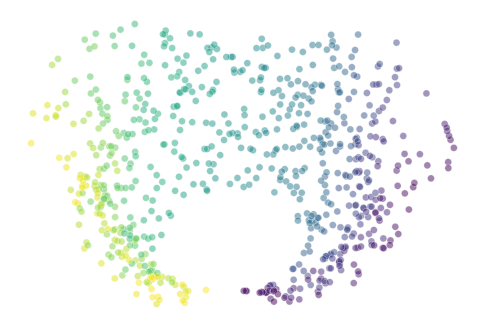

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7137535816618911), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.60980225), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.42884431709646614), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.5077077363896848), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.6119866284622731), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [14]:
pl.standard_eval(
    dataset="isofaces",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

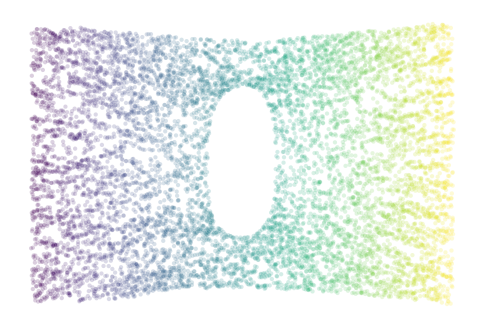

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.8771383482377697), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.8748598), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.8760161318604245), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.9007743293003683), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.9203471856917411), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [15]:
pl.standard_eval(
    dataset="scurvehole",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

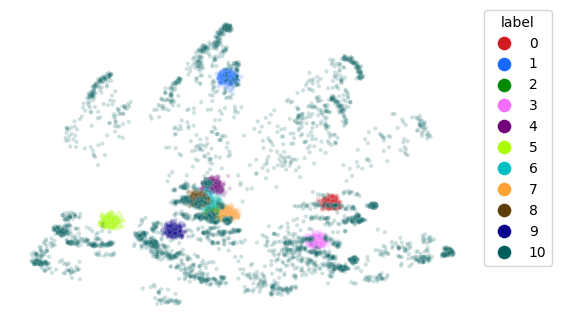

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.61204), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.36962664), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.016893333333333333), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.050642000000000006), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.14210466666666666), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [16]:
pl.standard_eval(
    dataset="spheres",
    method="isomap",
    params=dict(
        n_neighbors=15,
    ),
)

`isoswiss`, `scurvehole` and `isofaces` are pretty similar to the `sikmmds` results, which is a relief for me. `iris` also looks fine. But `s1k` doesn't seem to have much structure in the output and `spheres` also doesn't look as good to me. I wish I had the resources to force the larger datasets to produce an output but currently I am unable to do so.

So as far as I am concerned `sikmmds` does a pretty creditable job of emulating Isomap for manifold-structured data, and where manifold structure is less apparent it will produce nicer output (although perhaps just using neither is the right move there). It does also scale better than the scikit-learn version of Isomap.

## Concluding Thoughts

I am at best semi-intrigued by these embeddings. The MNIST results hint at some utility to this approach and some interesting structure emerges for some of the other datasets. And the method does succeed where Isomap fails on my machine, at least using the implementation with scikit-learn. I am sure there may be a better implementation but that's not really relevant because I don't claim that the knn-based approach is a real contender for a useful method in its current state. I have two major problems with it as it stands.

1. It takes a lot of epochs to optimize the results compared to UMAP and t-SNE and it's a lot more sensitive to learning rate selection than those methods, so you have to spend more time optimizing and more time trying different learning rates to get anything out of it. If this could be fixed I would be a lot more bullish about it. My guess is that the gradient is much less well-behaved than UMAP due to the square loss of the distance leading to much larger variance within the gradient vector and a lot more sensitivity of its magnitude dependent on dataset size and dimensionality. Maybe some processing of the gradient (scaling it?) or clipping the update or doing the optimization in batches within each epoch could help here? But that's a big job to work through and I haven't found anything satisfying yet, even if it is possible.
2. The fundamental observation from SPE about the ambient distance being a lower-bound on the true manifold distance is increasingly less helpful if the manifold has a larger dimensionality than the embedding dimension, i.e. if the manifold is more than 2D or 3D if you are trying to do visualization. Where distances must be necessarily distorted by the embedding, if the high-dimensional nearest neighbor distances aren't preserved, then what can we say about the reliability of the longer distances? Yes they are still a lower bound, but it's pretty clear that high-dimensional distances [are not a useful guide](https://github.com/jlmelville/drnb/blob/master/notebooks/embed-distances.ipynb) to the distribution in low dimensions, no matter what algorithm you use for dimensionality reduction. Maybe [ivhd](https://arxiv.org/abs/1902.01108) has the right idea here: just arbitrarily assign a single "large" distance to all negative samples and hope that preservation of the knn graph will hold things together structurally. Only needing to use a knn graph and distances would make this technique applicable to more datasets and would have the advantage of not involving any costly high-dimensional distance calculations or decisions to make about how many components to keep if PCA is appropriate as initial preprocessing step.